# FOOOF: Tuning & Troubleshooting

<div class="alert alert-success">
This notebook covers tips & tricks for setting FOOOF parameters, and tuning fits, and troubleshooting any issues.
</div>

<div class="alert alert-info">
If you want to first explore examples of using the FOOOF code base, go back [here](02-FOOOF.ipynb).
</div>

In [1]:
%matplotlib inline

import numpy as np

# FOOOF imports
from fooof import FOOOF, FOOOFGroup

# Import some utilities, and tools for creating synthetic power-spectra
from fooof.utils import mk_freq_vector
from fooof.synth import mk_fake_data, mk_fake_group_data
from fooof.core.utils import group_three

In [2]:
# Set random state, for to freeze the generate synthetic data
np.random.seed(321)

In [3]:
## Create a noisy synthetic PSD
# Background parameters, as [offset, slope]
bg = [20, 2]
# Oscillation parameters 
oscs = [10, 1.0, 2.5, 20, 0.8, 2, 32, 0.6, 1]

# Create the PSD
freqs, psd = mk_fake_data(mk_freq_vector([1, 50], 0.5), bg, oscs, nlv=0.1)

## FOOOF Settings

With default settings, FOOOF is minimally constrained. It defaults as such since there are not universal settings that work across all different dataset modalities. Appropriate settings also vary with PSD quality (noise, or effectively, the smoothness of the PSD), and frequency ranges. 

For any given dataset, FOOOF will likely need some tuning of parameters for optimal performance. 

To do so, we suggest using a combination of the following considerations:
- A priori constraints, given your data, such as the number of oscillations you expect to extract
- Qualitative analysis, guided by examing the the plotted model fit results, as compared to input data
- Quantitative analysis, considering the model fit and error (however, see note at the bottom regarding interpreting model fit error)

Tuning FOOOF is an imperfect art, and should be done carefully, as assumptions built into the settings chosen will impact the model results. 

We also recommend that FOOOF settings should not be changed between PSDs (across channels, trials, or subjects), if they are to be meaningfully compared. We therefore recommend first testing out FOOOF across some representative PSDs, in order to select FOOOF settings, which you then keep constant for the full analysis. 

### Tuning FOOOF

With the defaults, FOOOF is relatively unconstrained, and therefore, most commonly FOOOF will overfit, being overzealous at fitting small noisy bumps as oscillations. If you move to a new dataset, you may also find you need to relax some settings, for better fits. You also need to make sure you pick an appropriate background fitting procedure, and that your data meets the assumptions of the approach you choose. 

The remainder of this notebook goes through some examples of setting FOOOF parameters to be most appropriate for various datasetes.

## Interpreting Model Fit Quality Measures

FOOOF calculates and returns a couple metrics to assist with assessing the quality of the model fits. It calculates both the model fit error, as the root mean-squared error (RMSE) between the full psd_fit and the original PSD, as well as the model fit, as the R^2 correspondance between the original PSD and the model fit. 

These scores can be used to assess how the model is performing, however there interpretation can be a little nuanced. FOOOF is NOT optimized to minimize fit error at all costs. To do so typically results in fitting a large number of gaussian processes, in a way that overfits noise.

FOOOF is therefore built to measure PSD slope, and regions of oscillatory processes, optimized to a fuzzy definition of only fitting oscillations where there are actually oscillations (where an expert human rater would consider there to be an oscillatory 'bump'), as is not directly yoked to optimize model fit error / R^2.

Given this, while high error / low R^2 may indicate a poor model fit, very low error / high R^2 may also indicate a PSD that is overfit, in which case the oscillation parameters from the model may include overfitting to noise and thus not accurately reflect oscillatory regions. 

We therefore recommend that, for a given dataset, initial explorations should involve checking both cases in which model fit error is particularly large, or particularly low, and use these explorations to set parameters that are suitable for running across a group. There are not universal parameters that optimize this, and so FOOOF leaves it up to the user to set parameters appropriately to not under- or over-fit for a given modality / dataset / application.

### Reducing Overfitting

If FOOOF appears to be overfitting (for example, fitting too many gaussians to small bumps), try:

- Setting a lower-bound bandwidth-limit, to exclude 
- Setting a maximum number of oscillations that the algorithm may fit: max_n_oscs
    - If set, the algorithm will fit (up to) the _max_n_oscs_ highest power oscillations.
- Setting a minimum absolute amplitude for oscillations: min_amp


FOOOF WARNING: Lower-bound bandwidth limit is < or ~= the frequency resolution: 0.50 <= 0.50
	Lower bounds below frequency-resolution have no effect (effective lower bound is freq-res)
	Too low a limit may lead to overfitting noise as small bandwidth oscillations.
	We recommend a lower bound of approximately 2x the frequency resolution.


                                          FOOOF - PSD MODEL                                         

                    The input PSD was modelled in the frequency range: 1 - 50 Hz                    
                                  Frequency Resolution is 0.50 Hz                                   

                              Background Parameters (offset, slope):                                
                                          20.0549, 2.0230                                           

                                     7 oscillations were found:                                     
                                 CF:  10.10, Amp:

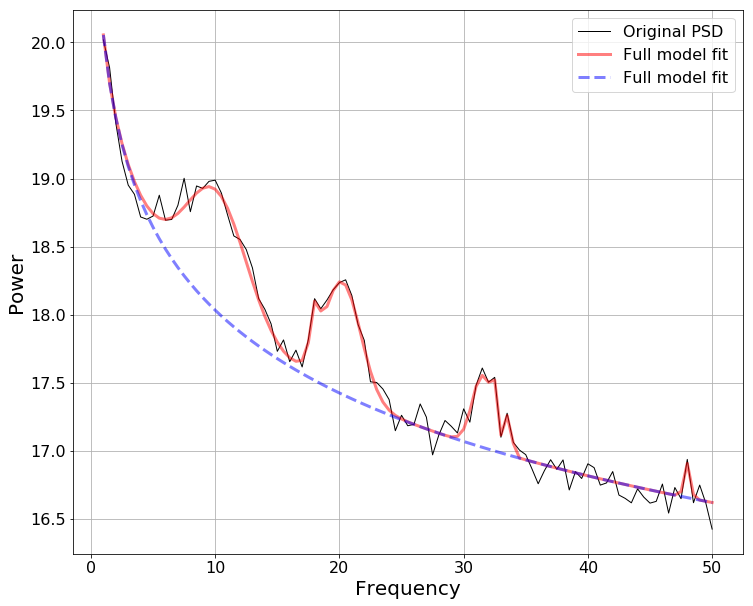

In [4]:
# Fit an (unconstrained) FOOOF model, liable to overfit
fm = FOOOF()
fm.model(freqs, psd)

Notice that in the above fit, we are very likely to think that FOOOF has been overzealous in fitting oscillations, and is therefore overfitting. 

This is also suggested by the model R^2, which is suspiciously high, given the amount of noise we expect. 

To reduce this kind of overfitting, we can update the FOOOF parameters.


                                          FOOOF - PSD MODEL                                         

                    The input PSD was modelled in the frequency range: 1 - 50 Hz                    
                                  Frequency Resolution is 0.50 Hz                                   

                              Background Parameters (offset, slope):                                
                                          20.0466, 2.0155                                           

                                     3 oscillations were found:                                     
                                 CF:  10.09, Amp:  0.892, BW:  4.86                                 
                                 CF:  20.05, Amp:  0.822, BW:  3.32                                 
                                 CF:  31.80, Amp:  0.522, BW:  2.21                                 

                                     R^2 of model fit is 0.9892                       

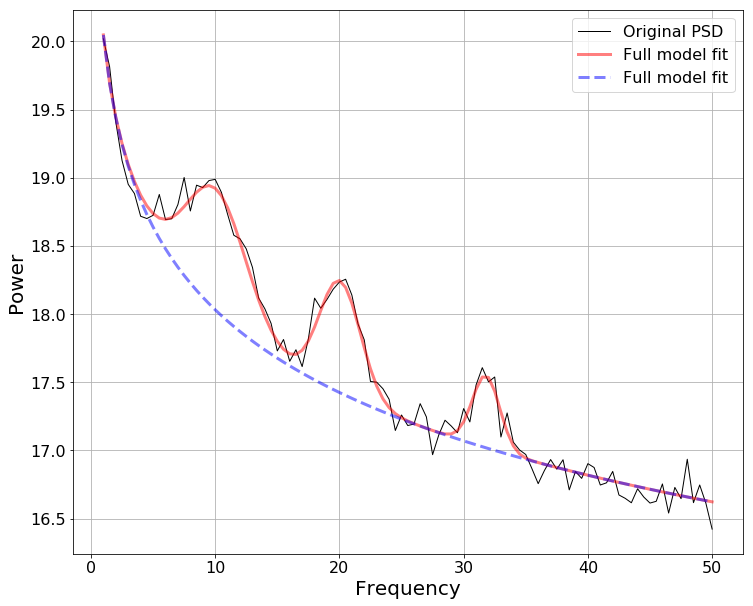

In [5]:
# Update settings to fit a more constrained FOOOF model, to reduce overfitting
fm = FOOOF(bandwidth_limits=[1, 8], max_n_oscs=6, min_amp=0.4)
fm.model(freqs, psd)

In [6]:
# The synthetic definition is defined in terms of gaussian parameters. 
#  Here, we can compare how FOOOF, with our updated settings, compares to the ground truth of the synthetic PSD
for sy, fi in zip(np.array(group_three(oscs)), fm._gaussian_params):
    print(sy, '\t', fi)

[ 10.    1.    2.5] 	 [ 10.09171095   0.89247344   2.42854977]
[ 20.    0.8   2. ] 	 [ 20.0505769    0.82184222   1.66001154]
[ 32.    0.6   1. ] 	 [ 31.80170268   0.53056698   1.10319569]


### Power spectra with no oscillations

A known case in which FOOOF can overfit is in power spectra in which no oscillations are present. In this case, the standard deviation can be very low, and so the relative amplitude check is very liberal at keeping gaussian fits. 

If you expect, or know, you have power-spectra without oscillations in your group, we therefore recommend updating _min_amp_ to some, even if it's a small value, as otherwise FOOOF is unlikely to appropriately fit PSDs as having no oscillations. 

### Reducing Underfitting

If you are finding that FOOOF is underfitting:
- First check and perhaps loosen any restrictions from _max_n_oscs_ and _min_amp_
- Try updating _amp_std_thresh_ to a lower value
- Bad fits may come from issues with background fitting. If so, see below. 

In [7]:
## Create a cleaner synthetic PSD, with smaller oscillations
# Background parameters, as [offset, slope]
bg = [20, 2]
# Oscillation parameters 
oscs = [10, 1.0, 1.0, 20, 0.3, 1.5, 32, 0.25, 1]

# Create the PSD
freqs, psd = mk_fake_data(mk_freq_vector([1, 50], 0.5), bg, oscs, nlv=0.025)


                                          FOOOF - PSD MODEL                                         

                    The input PSD was modelled in the frequency range: 1 - 50 Hz                    
                                  Frequency Resolution is 0.50 Hz                                   

                              Background Parameters (offset, slope):                                
                                          20.0090, 2.0051                                           

                                     3 oscillations were found:                                     
                                 CF:  10.00, Amp:  1.019, BW:  1.89                                 
                                 CF:  20.00, Amp:  0.306, BW:  2.90                                 
                                 CF:  32.08, Amp:  0.297, BW:  1.83                                 

                                     R^2 of model fit is 0.9993                       

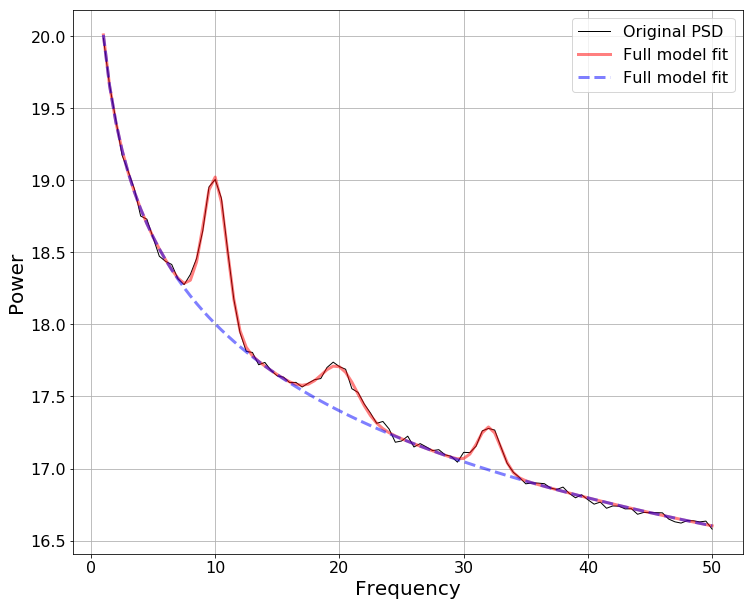

In [8]:
# Update settings to make sure they are sensitive to smaller oscillations in smoother PSDs
fm = FOOOF(bandwidth_limits=[1, 8], max_n_oscs=6, min_amp=0.2)
fm.model(freqs, psd)

In [9]:
# Check reconstructed parameters from synthetic definition
for sy, fi in zip(np.array(group_three(oscs)), fm._gaussian_params):
    print(sy, '\t', fi)

[ 10.   1.   1.] 	 [ 10.00458215   1.01865454   0.94689294]
[ 20.    0.3   1.5] 	 [ 20.00455993   0.30601155   1.45023314]
[ 32.     0.25   1.  ] 	 [ 32.08422607   0.29850532   0.91720714]


### Background Fitting

FOOOF currently offers two approaches to background fitting:
- Fitting a 1/f, as a linear fit in log-log
- Fitting a 1/f, including a 'knee' parameters, reflecting a fit with a bend, in log-log

Fitting without a knee assumes a singular 1/f background, and will go wrong if this assumption is violated.

Fitting with a knee is still experimental, with a couple outstanding issues:
- Interpreting the fit results when using knee fits is not 
- Fitting FOOOF with knee fits may perform sub-optimally in ambiguous cases (where the data may or may not have a knee)

Given this, we recommend:
- Check your data, across the frequency range of interest, for what the background looks like. 
    - If it looks to exhibit a single background (there appears to be a background line in log-log), fit without a knee. 
        - This is likely across smaller frequency ranges, such as 3-30. 
        - Do not fit no-knee fits across a range that this does not hold. 
    - If there is a clear knee then use knee fits. 
        - This is likely across larger fitting ranges such as 1-150 Hz. 
- Be wary of ambiguous ranges, where there may or may not be a knee.
    - Trying to fit without a knee, when there is not a single consistent 1/f can lead to very bad fits, but it is also a known issue that trying to fit with a knee can lead to suboptimal fits when no knee is present. 
        - We therefore currently recommend picking frequency ranges in which the expected background process is relatively clear. 

### Checking fits across a group

In [10]:
freqs, psds = mk_fake_group_data(mk_freq_vector([3, 50], 0.5), n_psds=10)

In [11]:
# Load FOOOFGroup
fg = FOOOFGroup(bandwidth_limits=[1, 6])


                                        FOOOF - GROUP RESULTS                                       

                                  Number of PSDs in the Group: 10                                   

                   The input PSDs were modelled in the frequency range: 3 - 50 Hz                   
                                  Frequency Resolution is 0.50 Hz                                   

                                   PSDs were fit without a knee.                                    

                                      Background Slope Values                                       
                               Min: 1.4995, Max: 2.4996, Mean: 1.9097                               

                       In total 62 oscillations were extracted from the group                       

                                        Fitting Performance                                         
                             R2s -  Min: 0.9991, Max: 1.0000, Mean: 0.9998          

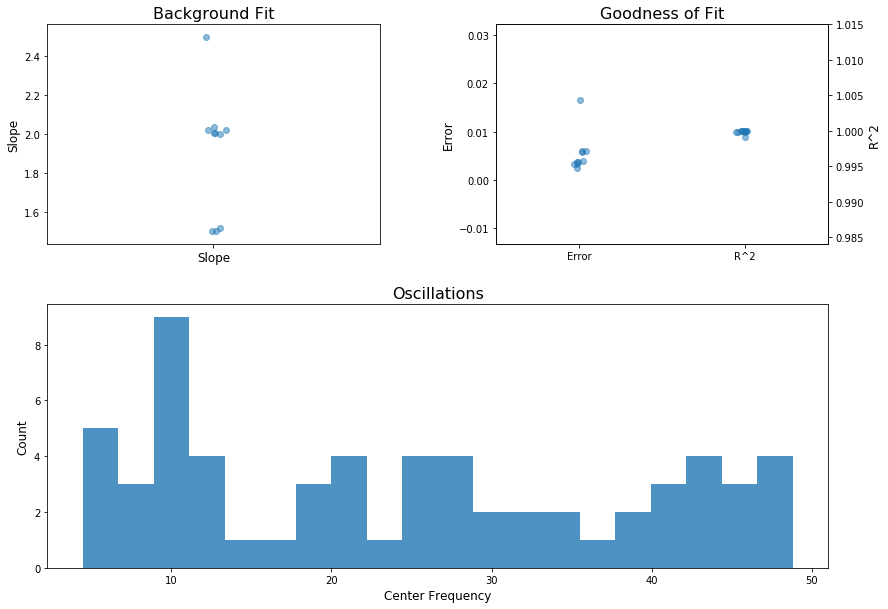

In [12]:
# Fit FOOOF to the group, and print out results
fg.model(freqs, psds)

Note that you can also extract 

In [13]:
# Find the index of the worst FOOOF fit from the group
worst_fit_ind = np.argmax(fg.get_all_data('error'))

# Extract this FOOOF fit from the group, into a FOOOF object, specifying to regenerate the full model
fm = fg.get_fooof(worst_fit_ind, regenerate=True)


                                          FOOOF - PSD MODEL                                         

                    The input PSD was modelled in the frequency range: 3 - 50 Hz                    
                                  Frequency Resolution is 0.50 Hz                                   

                              Background Parameters (offset, slope):                                
                                          20.0684, 2.0359                                           

                                     2 oscillations were found:                                     
                                 CF:  10.20, Amp:  0.472, BW:  3.88                                 
                                 CF:  20.13, Amp:  0.300, BW:  6.00                                 

                                     R^2 of model fit is 0.9991                                     
                           Root mean squared error of model fit is 0.0165             

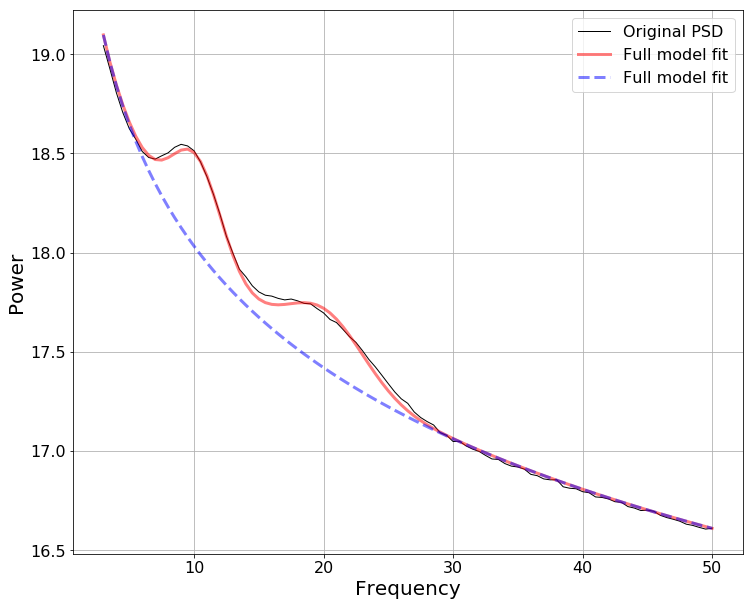

In [14]:
# Check out the model fit of the extracted FOOOF model
fm.print_results()
fm.plot()

You can also loop through all the results in a test group, extracting all fits that meet some criterion that makes them worth checking. 

This might be checking for fits above some error threshold, as below, but note that you may also want to do a similar procedure to examine fits with the lowest error, to check if FOOOF may be overfitting, or perhaps fits with a particularly large number of gaussians. 

In [15]:
# Extract all fits that are above some error threshold, for further examination. 
#  You could 
to_check = []
for ind, res in enumerate(fg):
    if res.error > 0.010:
        to_check.append(fg.get_fooof(ind, regenerate=True))

# A more condensed version of the procedure above can also be used, like this:
#to_check = [fg.get_fooof(ind, True) for ind, res in enumerate(fg) if res.error > 0.010]

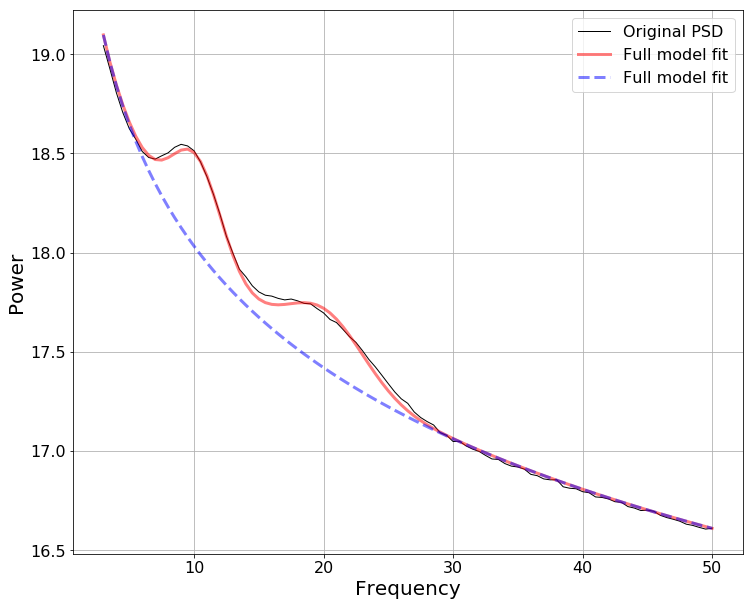

In [16]:
# Loop through the problem fits, checking the plots, and saving out reports, to check later. 
for ind, fm in enumerate(to_check):
    fm.plot()
    fm.create_report('Report_ToCheck_#' + str(ind))

### Reporting Bad Fits

If, after working through these suggestions, you are still getting bad fits, and/or are just not sure what is going on, please get in touch! We will hopefully be able to make further recommendations, and this also serves as a way for us to investigate when and why FOOOF fails, so that we can continue to make it better. 

You can report issues on Github [here](https://github.com/voytekresearch/fooof/issues), or get in touch with us by e-mail at voytekresearch@gmail.com. 

FOOOF also includes a helper method to print out instructions for reporting bad fits / bugs back to us, as demonstrated below.  


In [17]:
# Print out instructions to report bad fits
#  Note you can also call this from FOOOFGroup, and from instances (ex: fm.print_report_issue())
FOOOF.print_report_issue()


                             Contact / Reporting Information for FOOOF                              

                      Please report any bugs or unexpected errors on Github.                        
                           https://github.com/voytekresearch/fooof/issues                           

     If FOOOF gives you any weird / bad fits, we would like to know, so we can make it better!      
       To help us with this, send us a FOOOF report, and a FOOOF data file, for any bad fits.       

                With a FOOOF object (fm), after fitting, run the following commands:                
                              fm.create_report('FOOOF_bad_fit_report')                              
                          fm.save('FOOOF_bad_fit_data', True, True, True)                           

      Send the generated files ('FOOOF_bad_fit_report.pdf' & 'FOOOF_bad_fit_data.json') to us.      
                       We will have a look, and provide any feedback we can.          

<div class="alert alert-info">
To continue the tutorial, exploring further analysis of FOOOF results, go [here](06-FurtherAnalysis.ipynb).
</div>